In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [42]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("DynamicalClustering.jl"))
include(srcdirx("DataProcessing.jl"))

exp_name = "RE_Minimal_Inhibiting"

include(srcdirx("ExperimentSetups/Experiment_1/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using DynamicAxisWarping
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall
using DecisionTree
using CategoricalArrays
using ScikitLearn
using ShapML
using DataFrames

In [3]:
statmod = pyimport("statsmodels.graphics.mosaicplot")

plt = pyimport("matplotlib.pyplot")

pd = pyimport("pandas")

PyObject <module 'pandas' from '/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/pandas/__init__.py'>

In [4]:
function cond_save(dir,fig,cond)
    if cond
        CairoMakie.save(dir,fig)
    end
end

cond = false

false

In [5]:
color_scheme = cgrad(:tab10,categorical = true);

cp = palette([:purple,:red,:green,:yellow,:blue,:pink])

color_name = ["purple","red","green","yellow","blue","pink"]

fund_top_ndict = Dict(t=>n for (n,t) in enumerate(fundamental_topologies));

fund_top_dict = Dict(n=>t for (n,t) in enumerate(fundamental_topologies));

fund_top_dict[0] = "No assignment"

fund_top_ndict["No assignment"] = 0;

fund_top_dict_rv = Dict(j=>i for (i,j) in fund_top_dict);

network_topology_dict = Dict("feed_forward"=>w_feed_forward,"mutual_inh"=>w_mutual_inh,"frozen_osc"=>w_frozen_osc,"overlap_dom"=>w_overlap_dom,"bistable"=>w_bistable,"classical"=>w_classical);

#################################################################

weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

ci_indices_dict = Dict(ci=>i for (i,ci) in enumerate(CartesianIndex.(weight_indices)));

In [6]:
data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData_beta_1_mg_250k.jld2"));

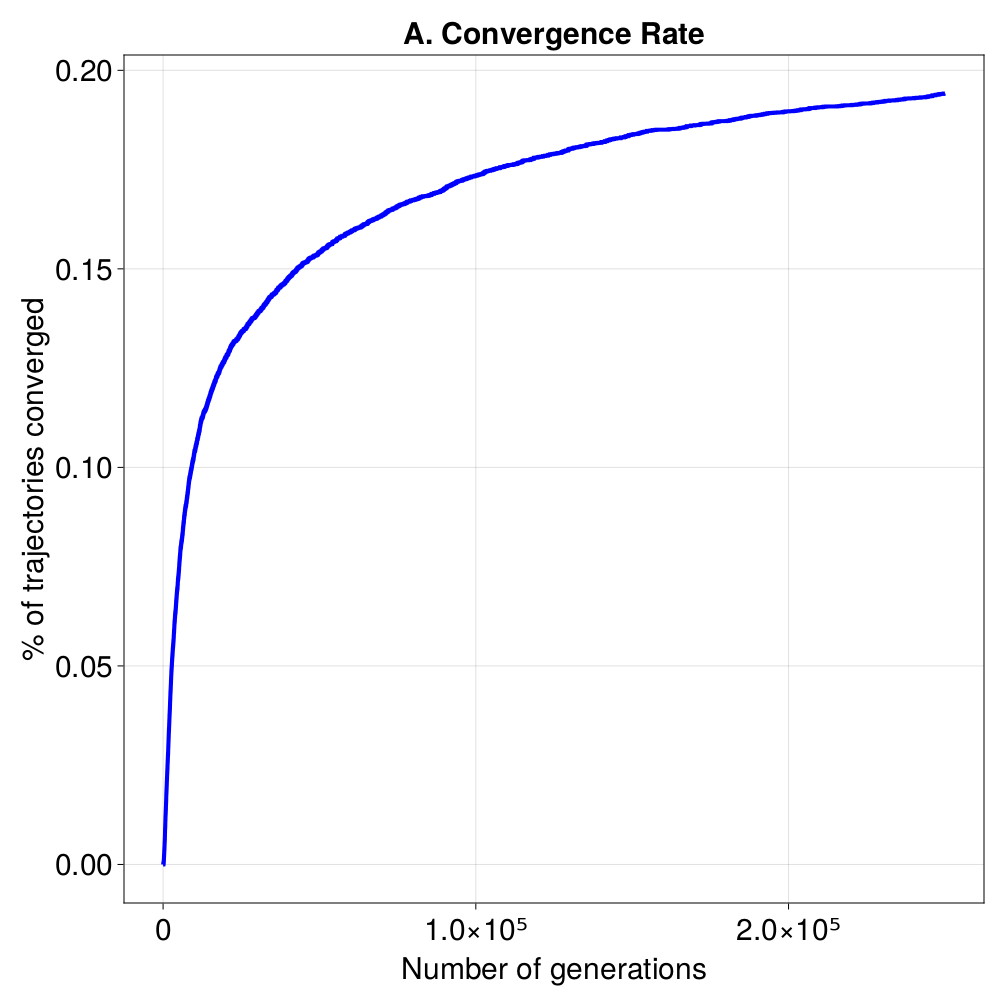

In [7]:
conv = copy(data["converged"]);

conv_time = map(x->length(x),data["fitness_traj"])

cum_conv = [sum(conv_time .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A. Convergence Rate",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

cond_save(plotsdirx("Experiment_1","ConvergenceRates.png"),fig,cond)

fig

In [8]:
fitness_traj_b = copy(data["fitness_traj"])[conv];

fitness_traj = map(t->map(x->x[2]+x[1],unique(t)),fitness_traj_b);

geno_traj = map(x->unique(x,dims =2),data["geno_traj"])[conv];

initial_fitness = fitness_traj[1][1];

initial_genotype = geno_traj[1][:,1];

In [9]:
fundamental_networks_dyn_cell = pmap(nt->get_rel_dyn_vector(nt[1],nt[2],n_steps,save_id),zip(fundamental_networks,fundamental_networks_t2s));
fundamental_networks_dyn_av = pmap(nt->get_av_dyn_vector(nt[1],nt[2],n_steps,n_segments),zip(fundamental_networks,fundamental_networks_t2s));

fund_X_cell = reduce(hcat,fundamental_networks_dyn_cell)
fund_X_av = reduce(hcat,fundamental_networks_dyn_av);


sim_m = copy(data["fund_dmat_cell"])

n_traj = sum(conv)

dmat_av = copy(data["dmat_av"]);

end_networks = map(v->v[:,end],data["geno_traj"]);

mind_class =  map(x->fundamental_labels[x[2]],argmin(sim_m,dims =2)) 

incl_top = reduce(hcat,map(en->[test_inclusion(en,vec(network_topology_dict[n])) for n in fundamental_topologies],end_networks)) |> transpose |> collect;

dyn_top_mind = zeros(Int,length(end_networks),length(fundamental_topologies))

top_assignment_mind = map(x->fund_top_ndict[x],mind_class)

for (net,t) in enumerate(top_assignment_mind)
    dyn_top_mind[net,t] = 1
end

########

class_labels = map(x->fund_top_dict[x],determine_class(incl_top,dyn_top_mind))[conv];

class_labels_u = unique(class_labels);

color_dict = Dict(i=>color_name[fund_top_ndict[i]+1] for i in class_labels_u)

Dict{String, String} with 4 entries:
  "bistable"      => "blue"
  "feed_forward"  => "red"
  "classical"     => "pink"
  "No assignment" => "purple"

In [10]:
mut_types = data["mut_type"][conv];
mut_choices = data["mut_choices"][conv]

dmc_re = map(mct->map(mc->map(x->ci_indices_dict[x],mc),mct),mut_choices)

dmc_re_sp = map(mct->map(x->sortperm(x),mct),dmc_re)

mut_choices_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(dmc_re,dmc_re_sp)];

mut_types_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(mut_types,dmc_re_sp)];

In [11]:
all_unique_fitness = unique(reduce(vcat,map(x->unique(x),fitness_traj)))

n_bin = 10

hist_edges = zeros(n_bin+1)

hist_edges[1] = initial_fitness

hist_edges[2:n_bin] .= LinRange(initial_fitness+eps(),0.9,n_bin-1) |> collect

hist_edges[n_bin+1] = 1.

n_fit_bin = length(hist_edges) - 1

h_fitness = fit(Histogram, all_unique_fitness, hist_edges; closed = :left) 

fitness_routes = map(traj->map(f->StatsBase.binindex(h_fitness, f),unique(traj)),fitness_traj);

wait_times = map(fb->unique(i -> fb[i], 1:length(fb)),fitness_traj_b)

wait_times_mutant = map(x->x[2:end] .- x[1:end-1],wait_times)

3883-element Vector{Vector{Int64}}:
 [44, 5, 9, 436, 3926, 8035, 168]
 [61, 431, 3483, 108, 1855, 20171, 11, 2, 42, 1, 335]
 [53, 108, 84, 60, 79, 1013, 274, 558, 4, 106, 44, 111, 52]
 [24, 626, 8600, 69]
 [94, 12, 16, 11, 142174, 34, 145, 376, 42, 554]
 [3, 189, 728, 120, 11708, 2260, 12344, 69, 185, 147]
 [94, 32, 44, 105, 34, 45, 9, 3117, 46, 5, 616, 471]
 [13, 796, 597, 120, 307, 67109, 573, 53, 153, 579, 1648]
 [36, 35, 1, 13211, 15534, 1, 17, 28, 1320, 3206, 265]
 [108, 650, 4190, 139]
 ⋮
 [146, 21, 46, 40, 117, 3728, 17112, 100, 134, 23, 96, 575, 94, 1091, 3104, 3813, 1109, 1603]
 [54, 295, 243, 1427, 91, 1, 129, 37, 1106, 2152]
 [234, 60, 78, 1246, 1064, 92950, 286]
 [30, 461, 89, 471, 353, 160, 97, 182, 11431, 89, 144, 186, 12]
 [4, 19, 6, 110566, 50, 1661, 127, 321]
 [36, 180, 2943, 1]
 [35, 29, 1, 252, 37, 18, 67, 915, 188]
 [91, 45, 824, 9267, 30, 31, 11, 16, 2, 50, 18]
 [73, 308, 1110, 3, 204, 43, 654]

In [12]:
clust_labels = copy(class_labels);

In [13]:
mut_id = map(x->get_mutation_id(unique(x,dims = 2)),geno_traj);

mut_id_labels = map(v->map(x->weight_names[x],v),mut_id);

mut_id_labels = map(v->map(x->(n_mut=length(x),mut_id_name=join(map(i->weight_names[i],x),"|"),mut_id=x),v),mut_id);

mut_dist = map(x->get_mutant_dist(unique(x,dims = 2)),geno_traj);

fitness_delta = map(x->get_fitness_delta(unique(x)),fitness_traj);

actual_fitness = map(x->x[1:end-1],fitness_traj);

actual_networks = map(x->[x[:,j] for j in 1:size(x[:,1:end-1],2)],geno_traj);

actual_mutant = map(x->[j for j in 1:size(x[:,1:end-1],2)],geno_traj);

mut_id_label_type = [[(mut_type=mut_typ,midl...) for (mut_typ,midl) in zip(mut_types_ro[i],mut_id_labels[i])] for i in 1:length(mut_id_labels)];

mut_id_wait_time = [[(wait_time=wt,midl...) for (wt,midl) in zip(wait_times_mutant[i],mut_id_label_type[i])] for i in 1:length(mut_id_label_type)];

mut_id_size_label = [[(mut_size=mut_size,midl...) for (mut_size,midl) in zip(mut_dist[i],mut_id_wait_time[i])] for i in 1:length(mut_id_wait_time)];

mut_id_size_label_am = [[(mut_number=mut_number,midl...) for (mut_number,midl) in zip(actual_mutant[i],mut_id_size_label[i])] for i in 1:length(mut_id_size_label)];

mut_id_size_label_an = [[(existing_network=network,midl...) for (network,midl) in zip(actual_networks[i],mut_id_size_label_am[i])] for i in 1:length(mut_id_size_label_am)];

mut_id_size_label_af = [[(existing_fitness=fitness,midl...) for (fitness,midl) in zip(actual_fitness[i],mut_id_size_label_an[i])] for i in 1:length(mut_id_size_label_an)];

mut_id_size_label_fb = [[(fitness_bin=fb,midl...) for (fb,midl) in zip(fitness_routes[i],mut_id_size_label_af[i])] for i in 1:length(mut_id_size_label_af)];

mut_id_size_label_fb_ft = [[(fitness_delta=fd,midl...) for (fd,midl) in zip(fitness_delta[i],mut_id_size_label_fb[i])] for i in 1:length(mut_id_size_label_fb)];

mut_id_size_label_fb_cc = [[(cluster_id=clust_labels[i],midl...) for midl in mut_id_size_label_fb_ft[i]] for i in 1:length(mut_id_size_label_fb_ft)];

mut_info = [[(traj_id=i,midl...) for midl in mut_id_size_label_fb_cc[i]] for i in 1:length(mut_id_size_label_fb_cc)];

all_mut_info = reduce(vcat,mut_info);

In [14]:
function evaluate_epistasis_pairwise(mut_tuple,grn_parameters,development,fitness_function)

    n_mut_to_evaluate = length(mut_tuple[:mut_id])

    if typeof(mut_tuple[:existing_fitness]) == Tuple{Float64,Float64}
        existing_fitness = mut_tuple[:existing_fitness][1] + mut_tuple[:existing_fitness][2]
        og_mutant_fitness = existing_fitness + mut_tuple[:fitness_delta]
    else
        existing_fitness = mut_tuple[:existing_fitness]
        og_mutant_fitness = existing_fitness + mut_tuple[:fitness_delta]
    end

    new_mutant_fitness = []

    new_mutant_weight_signs = []

    new_mutant_noise_signs = []

    for n in 1:n_mut_to_evaluate

        new_network = noise_specified(mut_tuple[:existing_network],mut_tuple[:mut_id][n],mut_tuple[:mut_size][n],mut_tuple[:mut_type][n])

        mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

        nmf = fitness_function(mutant.phenotype)

        if typeof(nmf) == Tuple{Float64,Float64}
            nmf = nmf[1] + nmf[2]
        end

        push!(new_mutant_fitness,nmf)
        push!(new_mutant_weight_signs,sign(new_network[mut_tuple[:mut_id][n]]))
        push!(new_mutant_noise_signs,sign(mut_tuple[:mut_size][n]))

    end

    # return  existing_fitness,og_mutant_fitness,Dict(mid=>nf for (mid,nf) in zip(mut_tuple[:mut_id],new_mutant_fitness))

    r = Dict()

    r1 =  Dict(mid=>nf for (mid,nf) in zip(mut_tuple[:mut_id],(new_mutant_fitness .+ 2) ./ (og_mutant_fitness + 2)))

    r1[-1] = mut_tuple[:existing_fitness] + 2
    r1[-2] = mut_tuple[:fitness_delta]

    r2 = Dict(mid=>nf for (mid,nf) in zip(mut_tuple[:mut_id],new_mutant_weight_signs))
    r3 = Dict(mid=>nf for (mid,nf) in zip(mut_tuple[:mut_id],new_mutant_noise_signs))

    return r1, r2, r3
end

function evaluate_epistasis_class(mut_tuple,grn_parameters,development,fitness_function)

    n_mut_to_evaluate = length(mut_tuple[:mut_id])

    if typeof(mut_tuple[:existing_fitness]) == Tuple{Float64,Float64}
        existing_fitness = mut_tuple[:existing_fitness][1] + mut_tuple[:existing_fitness][2]
        og_mutant_fitness = existing_fitness + mut_tuple[:fitness_delta]
    else
        existing_fitness = mut_tuple[:existing_fitness]
        og_mutant_fitness = existing_fitness + mut_tuple[:fitness_delta]
    end

    new_mutant_fitness = []

    new_mutant_weight_signs = []

    new_mutant_noise_signs = []

    for n in 1:n_mut_to_evaluate

        new_network = noise_specified(mut_tuple[:existing_network],mut_tuple[:mut_id][n],mut_tuple[:mut_size][n],mut_tuple[:mut_type][n])

        mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

        nmf = fitness_function(mutant.phenotype)

        if typeof(nmf) == Tuple{Float64,Float64}
            nmf = nmf[1] + nmf[2]
        end

        push!(new_mutant_fitness,nmf)
        push!(new_mutant_weight_signs,sign(new_network[mut_tuple[:mut_id][n]]))
        push!(new_mutant_noise_signs,sign(mut_tuple[:mut_size][n]))

    end

    # return  existing_fitness,og_mutant_fitness,Dict(mid=>nf for (mid,nf) in zip(mut_tuple[:mut_id],new_mutant_fitness))

    accept_mutation = new_mutant_fitness .> existing_fitness

    if accept_mutation[1] & accept_mutation[2]

        if maximum(new_mutant_fitness) > og_mutant_fitness
            r1 = Dict(mt=>:nonsyn for mt in mut_tuple[:mut_id])
        else
            r1 = Dict(mt=>:syn for mt in mut_tuple[:mut_id])
        end

    elseif (accept_mutation[1] & !accept_mutation[2])
        r1 = Dict(mut_tuple[:mut_id][1]=>:carrier,mut_tuple[:mut_id][2]=>:hitchhike)
    elseif (!accept_mutation[1] & accept_mutation[2])
        r1 = Dict(mut_tuple[:mut_id][1]=>:hitchhike,mut_tuple[:mut_id][2]=>:carrier)
    else
        r1 = Dict(mt=>:rse for mt in mut_tuple[:mut_id])
    end

    return r1
end

function fixation_prob_non_negative(fitness_delta,β)
    return max(0.,fixation_probability(fitness_delta,β))
end

function evaluate_epistasis(mut_tuple,geno_traj,fitness_traj,grn_parameters,development,fitness_function)

    n_mut_max = mut_tuple[:mut_number] - 1

    new_mutant_fitness_delta = []
    new_mutant_fitness_delta_rel = []
    new_mutant_accept_prob = []

    for i in 1:n_mut_max

        new_network = noise_specified(geno_traj[mut_tuple[:traj_id]][:,i],mut_tuple[:mut_id],mut_tuple[:mut_size],mut_tuple[:mut_type])

        mutant = Individual(reshape(new_network,(3,4)),grn_parameters,development)

        nmf = fitness_function(mutant.phenotype)

        if typeof(nmf) == Tuple{Float64,Float64}
            nmf = nmf[1] + nmf[2]
        end

        push!(new_mutant_fitness_delta,(mut_tuple[:mut_number] - i,nmf - fitness_traj[mut_tuple[:traj_id]][i]))
        push!(new_mutant_fitness_delta_rel,(mut_tuple[:mut_number] - i,(nmf - fitness_traj[mut_tuple[:traj_id]][i])/mut_tuple[:fitness_delta]))
        push!(new_mutant_accept_prob,(mut_tuple[:mut_number] - i,fixation_prob_non_negative(nmf - fitness_traj[mut_tuple[:traj_id]][i],β)/fixation_prob_non_negative(mut_tuple[:fitness_delta],β)))

    end

    return [new_mutant_accept_prob,new_mutant_fitness_delta_rel,new_mutant_fitness_delta]
end

function characterise_epi(d)
    v = values(d) |> collect

    if :rse in v
        return (1,"RSE")
    elseif :carrier in v
        return (2,"Carrier/Hitchhike")
    else
        return (3,"Syn/NonSyn")
    end

end

characterise_epi (generic function with 1 method)

In [15]:
function mask(network,topology)

    new_network = copy(network)

    z0 = findall(x->x == 0,topology)

    new_network[z0] .= 0.

    return new_network

end

mask (generic function with 1 method)

In [16]:
hamming_distance_all = [reduce(hcat,map(en->[Distances.evaluate(Hamming(),mask(sign.(en),vec(network_topology_dict[n])),vec(network_topology_dict[n])) for n in fundamental_topologies],eachcol(geno_traj[i]))) |> collect for i in 1:length(geno_traj)];

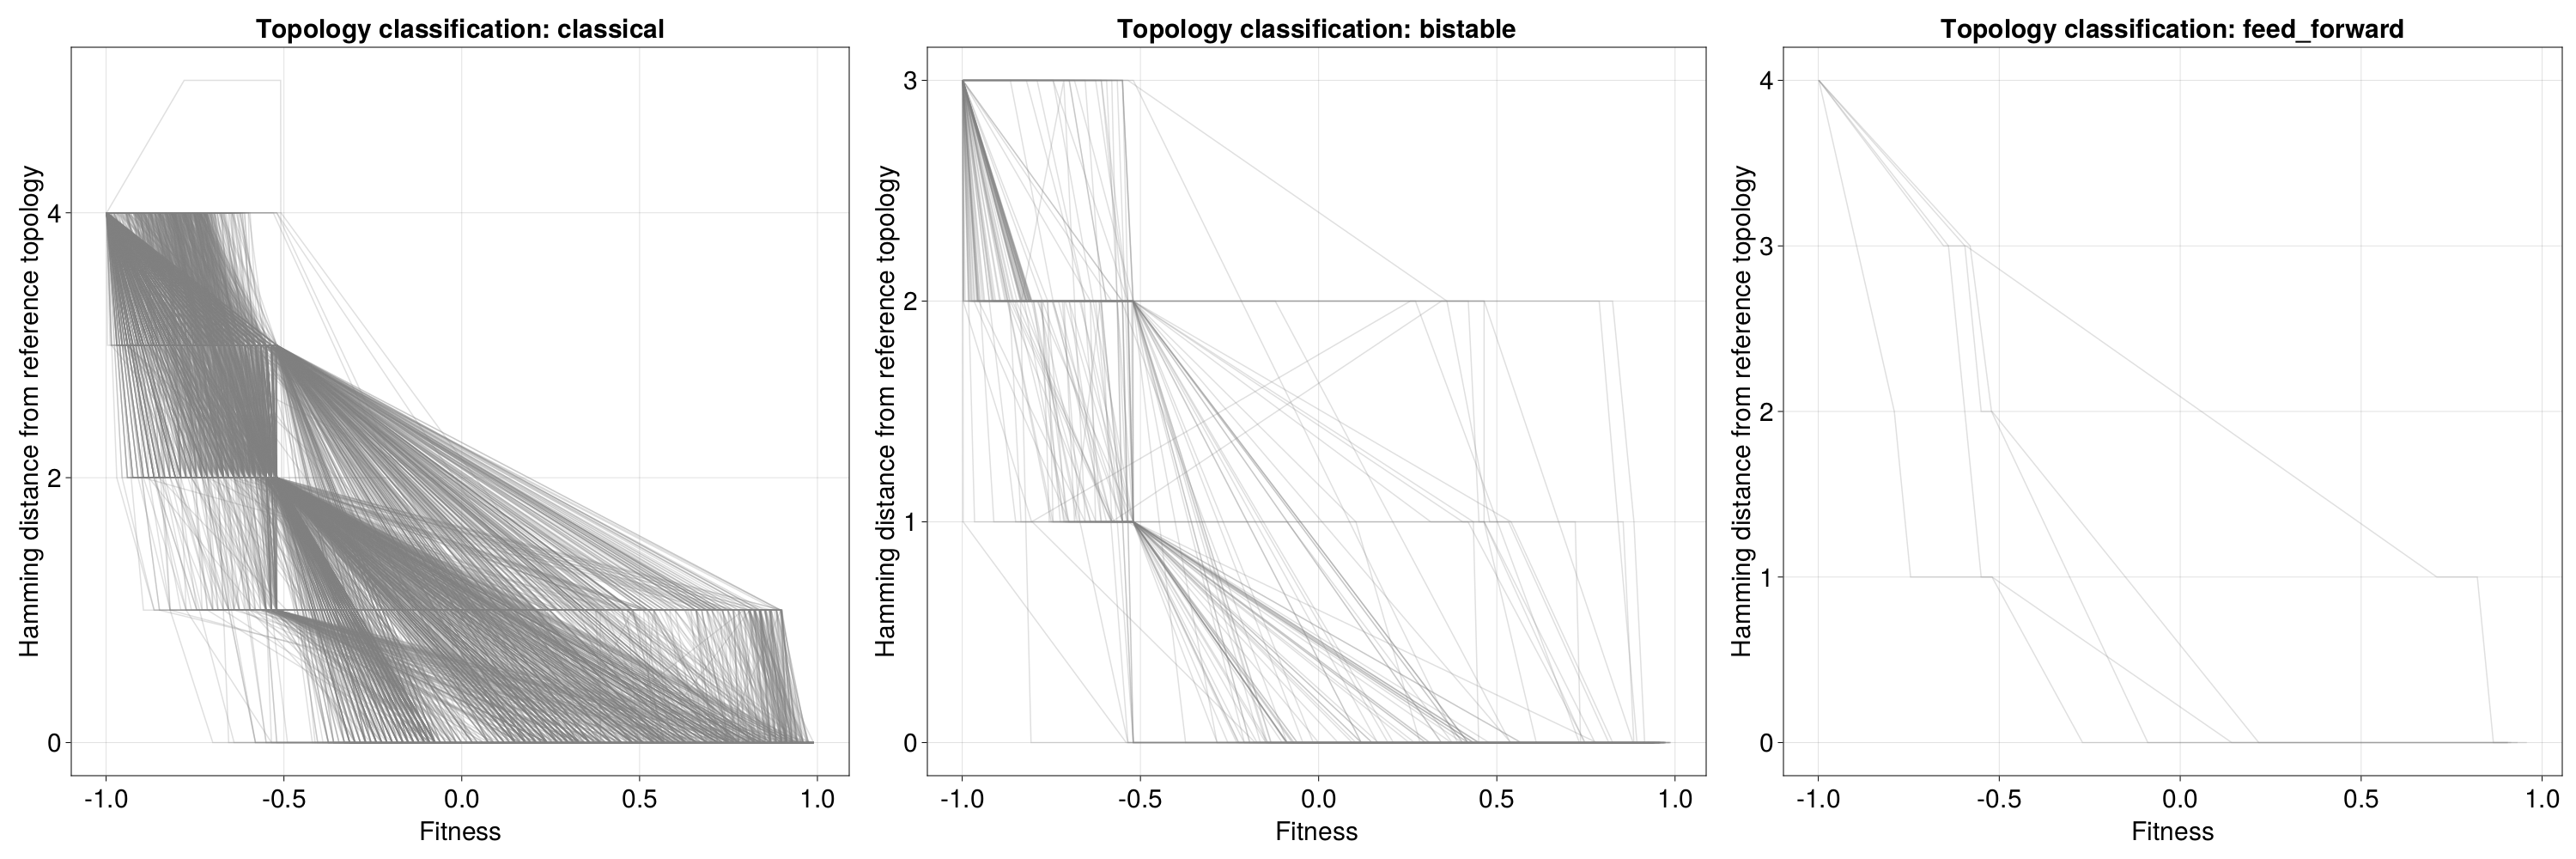

In [17]:
fig = CairoMakie.Figure(resolution = (3000,1000),fontsize = 30.)

for (n,top) in enumerate(filter(x->x!= "No assignment",class_labels_u))

    ax = Axis(fig[1,n],title = "Topology classification: " * top, ylabel = "Hamming distance from reference topology",xlabel = "Fitness")

    cl_hm = [[(f,h[fund_top_ndict[top]]) for (h,f) in zip(eachcol(hamming_distance_all[i]),fitness_traj[i])] for i in 1:length(fitness_traj)];

    for dp in cl_hm[class_labels .== top]

        CairoMakie.lines!(ax,dp,color = (:grey, 0.25))
    end

end

cond_save(plotsdirx("Experiment_1/BranchingPoints","HammingDistanceFromReference.png"),fig,true)

fig

In [18]:
stripe_achieved = map(x->minimum(findall(x->x[1] == 0.,unique(x))),fitness_traj_b);

zham_id =  map(hd->findall(y->any(y .== 0),eachcol(hd)),hamming_distance_all);

zham_achieved = [length(x) == 0 ? Inf : minimum(x) for x in zham_id];

zham_achieved_n = [length(x) == 0 ? -1 : minimum(x) for x in zham_id];

#####################

zham_le = zham_achieved .<= stripe_achieved

zham_l = zham_achieved .< stripe_achieved

zham_equals = zham_achieved .== stripe_achieved

zham_n = zham_achieved .== Inf

zham_g = (zham_achieved .> stripe_achieved) .& .!(zham_n);

@assert sum(zham_l) + sum(zham_equals) + sum(zham_n) + sum(zham_g) == length(fitness_traj)

zham_time_class = zeros(Int,length(fitness_traj))

zham_time_class[zham_l] .= 1
zham_time_class[zham_equals] .= 2
zham_time_class[zham_g] .= 3
zham_time_class[zham_n] .= 4

zham_s = .!zham_n;

sum(zham_s) / length(zham_s)

0.45068246201390677

In [19]:
zham_top = [findall(x->x==0,hd[:,zid]) for (zid,hd) in zip(zham_achieved[zham_s],hamming_distance_all[zham_s])]

end_top = [findall(x->x==0,hdm[:,end]) for hdm in hamming_distance_all[zham_s]]

zham_incl_end =  [all([x in etop for x in ztop]) for (ztop,etop) in zip(zham_top,end_top)]

zham_is_end =  [etop == ztop for (ztop,etop) in zip(zham_top,end_top)];

#########################

zham_trans = findall(zham_s) 

zham_trans_id =  map(x->x-1,zham_achieved[zham_trans])

zham_mutation = [condition_data_return_tuples([:traj_id,:mut_number],[t,m],all_mut_info)[1] for (t,m) in zip(zham_trans,zham_trans_id)];

zham_trans_hd = [hamming_distance_all[t][:,m] for (t,m) in zip(zham_trans,zham_trans_id)];

#########################

zham_trans_min_hd = map(x->minimum(x),zham_trans_hd);

zham_trans_min_hd_top = map(x->argmin(x),zham_trans_hd)

zham_top_incl_min_hd =  [all([x in etop for x in ztop]) for (ztop,etop) in zip(zham_trans_min_hd_top,zham_top)]

#########################

stripe_trans_id = map(x->x-1,stripe_achieved[zham_trans])

stripe_mutation = [condition_data_return_tuples([:traj_id,:mut_number],[t,m],all_mut_info)[1] for (t,m) in zip(zham_trans,stripe_trans_id)];

In [20]:
print(unique(end_top))

[[5], [4], Int64[], [1, 2], [1]]

In [21]:
print(unique(zham_top))

[[5], [4], [1, 2], [1], [2]]

In [22]:
# top_types = unique(reduce(vcat,[zham_top,end_top]))

# top_type_ndict = Dict(t=>n for (n,t) in enumerate(top_types))

# top_type_ndictr = Dict(l=>f for (f,l) in top_type_ndict)

# top_type_dict = Dict(t=> length(t) > 0 ? join([fund_top_dict[i] for i in t], "|") : "No assignment" for (n,t) in enumerate(top_types))

# top_type_cdict = Dict("feed_forward"=>"red","No assignment"=>"purple","classical"=>"pink","bistable"=>"blue","mutual_inh"=>"green","feed_forward|mutual_inh"=>"orange");

In [23]:
epi_result_branch = map(x->evaluate_epistasis_class(x,grn_parameters,DefaultGRNSolver(),fitness_function),filter(x->x[:n_mut] == 2,zham_mutation));

epi_class_branch = map(x->characterise_epi(x)[1],epi_result_branch);

epi_branch_plot_data = [i for i in zip(map(x->x[:cluster_id],zham_mutation),epi_class_branch)];

In [24]:
mut_new = condition_data_incl_return_tuples([],[],[:mut_type],[:new],all_mut_info);
mut_existing = condition_data_excl_return_tuples([],[],[:mut_type],[:new],all_mut_info);

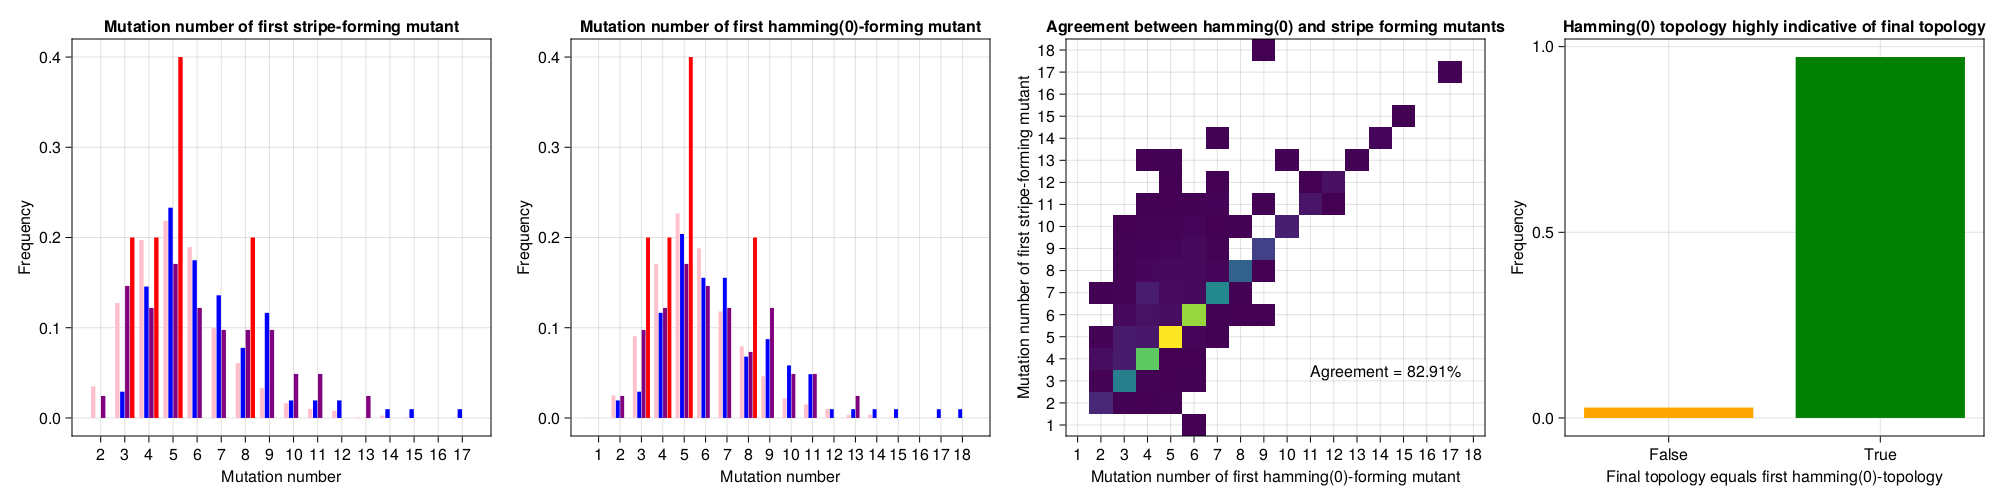

In [25]:
fig = CairoMakie.Figure(resolution = (2000,500))

d1 = map(x->x[:mut_number],stripe_mutation)
d2 = map(x->x[:mut_number],zham_mutation)

min_mut = minimum(reduce(vcat,[d1,d2]))
max_mut = maximum(reduce(vcat,[d1,d2]))

drange = min_mut:max_mut

d = zeros(length(drange),length(drange))

for (ni,i) in enumerate(drange)
    for (nj,j) in enumerate(drange)
        x = count(x->(x[1] == i) & (x[2] == j),zip(d1,d2))
        d[ni,nj] = x .!= 0 ? x : NaN

    end
end

ax1 = Axis(fig[1,1], title = "Mutation number of first stripe-forming mutant", xlabel = "Mutation number", ylabel = "Frequency")
create_bar_from_tuples!(ax1,map(x->(x[:cluster_id],x[:mut_number]),stripe_mutation),color_dict,true)

ax1.xticks = (minimum(d1):1:maximum(d1),string.(minimum(d1):1:maximum(d1)))

ax2 = Axis(fig[1,2], title = "Mutation number of first hamming(0)-forming mutant", xlabel = "Mutation number", ylabel = "Frequency")
create_bar_from_tuples!(ax2,map(x->(x[:cluster_id],x[:mut_number]),zham_mutation),color_dict,true)

ax2.xticks = (minimum(d2):1:maximum(d2),string.(minimum(d2):1:maximum(d2)))

ax3 = Axis(fig[1,3], xlabel = "Mutation number of first hamming(0)-forming mutant", ylabel = "Mutation number of first stripe-forming mutant",title = "Agreement between hamming(0) and stripe forming mutants")
CairoMakie.heatmap!(ax3,d)

CairoMakie.text!(ax3,[Point2f(11,3)],text = ["Agreement = " * string(round(sum(zham_equals[zham_s])*100/sum(zham_s),digits =2)) * "%"])

ax3.xticks = (drange, string.(drange))
ax3.yticks = (drange, string.(drange))

ax4 = Axis(fig[1,4], ylabel = "Frequency", xlabel = "Final topology equals first hamming(0)-topology",title = "Hamming(0) topology highly indicative of final topology")
CairoMakie.barplot!(ax4,[0,1],[countmap(zham_incl_end)[x]/length(zham_incl_end) for x in [0,1]],color = [:orange,:green])

ax4.xticks = (0:1,["False","True"])

# d1 = map(x->top_type_dict[x],zham_top)

# ax4 = Axis(fig[1,4], ylabel = "Frequency")
# create_bar_from_tuples!(ax4,[x for x in zip(d1,zham_incl_end)],top_type_cdict,true)

# ax4.xticks = (0:1,["Topology change","Remained hamming(0)-topology"])

cond_save(plotsdirx("Experiment_1/BranchingPoints","StripeVsHammingZ.png"),fig,true)

fig

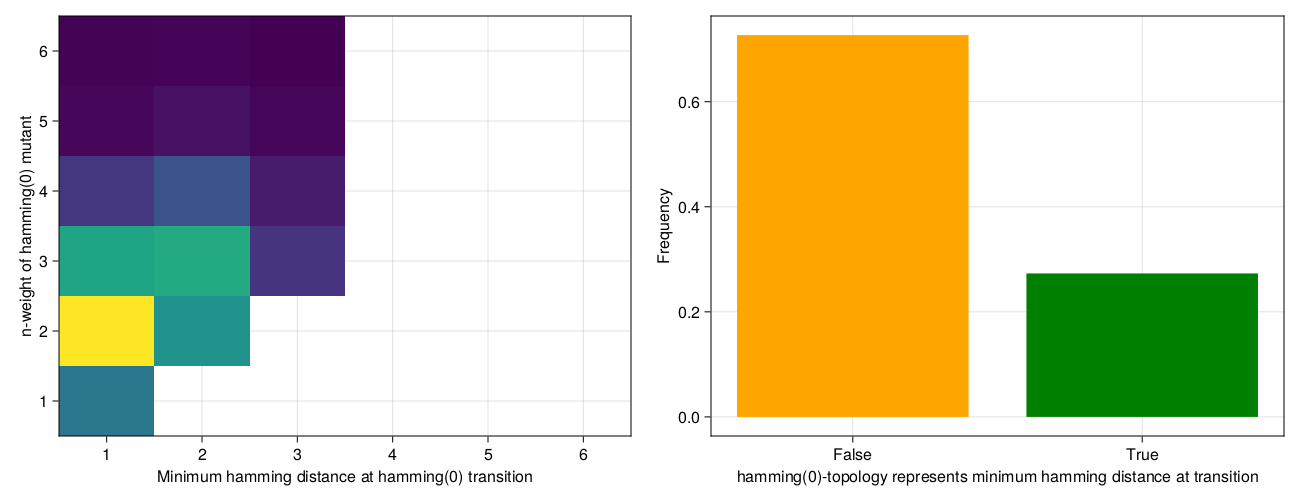

In [26]:
d1 = copy(zham_trans_min_hd)
d2 = map(x->x[:n_mut],zham_mutation)

min_mut = minimum(reduce(vcat,[d1,d2]))
max_mut = maximum(reduce(vcat,[d1,d2]))

drange = min_mut:max_mut

d = zeros(length(drange),length(drange))

for (ni,i) in enumerate(drange)
    for (nj,j) in enumerate(drange)
        x = count(x->(x[1] == i) & (x[2] == j),zip(d1,d2))
        d[ni,nj] = x .!= 0 ? x : NaN
    end
end

fig = CairoMakie.Figure(resolution = (1300,500))

ax1 = Axis(fig[1,1], xlabel = "Minimum hamming distance at hamming(0) transition", ylabel = "n-weight of hamming(0) mutant")
CairoMakie.heatmap!(ax1,d)

ax1.xticks = (1:6, string.(1:6))
ax1.yticks = (1:6, string.(1:6))

ax2 = Axis(fig[1,2], ylabel = "Frequency", xlabel = "hamming(0)-topology represents minimum hamming distance at transition")
CairoMakie.barplot!(ax2,[0,1],[countmap(zham_top_incl_min_hd)[x]/length(zham_top_incl_min_hd) for x in [0,1]],color = [:orange,:green])

ax2.xticks = (0:1,["False","True"])

cond_save(plotsdirx("Experiment_1/BranchingPoints","HammingGraphNaivelyNonInformative.png"),fig,true)

fig

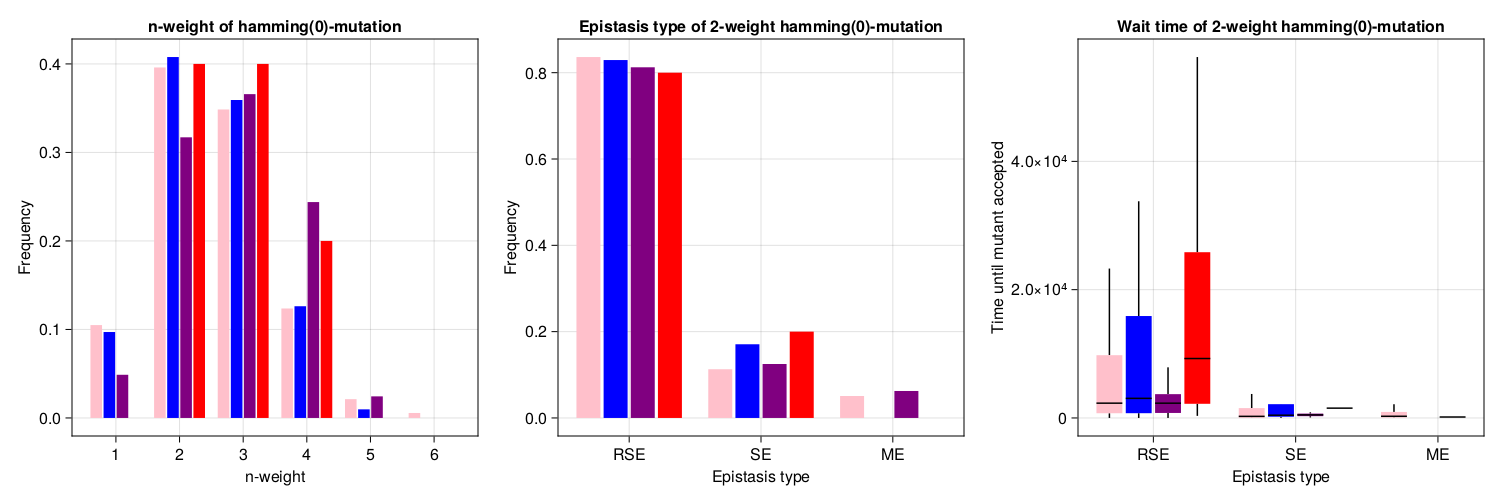

In [27]:
# Add number of mutation distribution for all mutations as comparison

fig = CairoMakie.Figure(resolution = (1500,500))

ax1 = Axis(fig[1,1], xlabel = "n-weight", ylabel = "Frequency",title = "n-weight of hamming(0)-mutation")
create_bar_from_tuples!(ax1,map(x->(x[:cluster_id],x[:n_mut]),zham_mutation),color_dict,true)

ax2 = Axis(fig[1,2], xlabel = "Epistasis type", ylabel = "Frequency",title = "Epistasis type of 2-weight hamming(0)-mutation")
create_bar_from_tuples!(ax2,epi_branch_plot_data,color_dict,true)

ax2.xticks = (1:3,["RSE","SE","ME"])

# linkyaxes!([ax1,ax2,ax3]...)

ax3 = Axis(fig[1,3], xlabel = "Epistasis type", ylabel = "Time until mutant accepted",title = "Wait time of 2-weight hamming(0)-mutation")

wt = map(x->x[:wait_time],filter(x->x[:n_mut] == 2,zham_mutation))

reorder_dict = Dict("classical"=>1,"bistable"=>2,"No assignment"=>3,"feed_forward"=>4)

CairoMakie.boxplot!(ax3,epi_class_branch,wt,dodge = map(x->reorder_dict[x],first.(epi_branch_plot_data)),color = map(x->color_dict[x],first.(epi_branch_plot_data)),show_outliers = false)

ax3.xticks = (1:3,["RSE","SE","ME"])

cond_save(plotsdirx("Experiment_1/BranchingPoints","EpistasisTypes.png"),fig,true)

fig

# boxplot time to find mutant for RSE vs SE vs ME, also potentially by topological classification
# How does the n-weight of the hamming(0) mutant correlate with the minimimum hamming distance to a given topology prior to the transition?
#

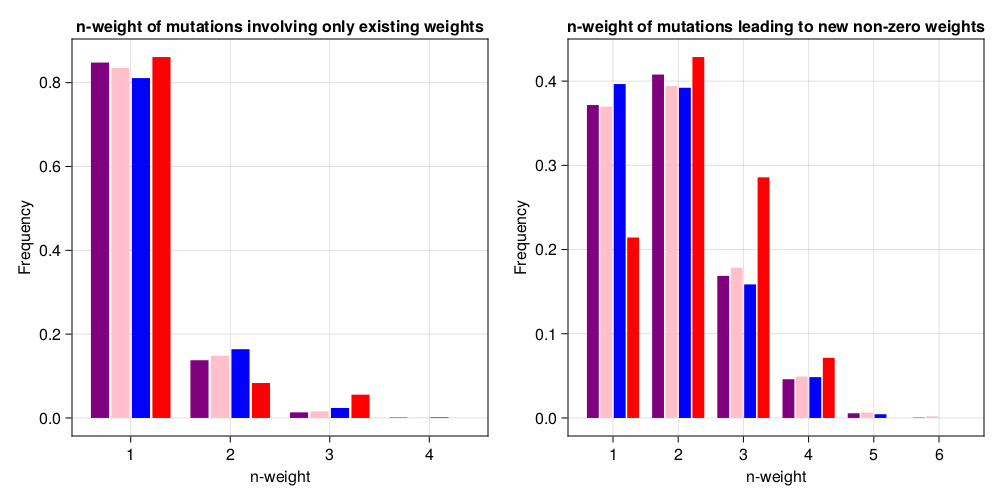

In [28]:
fig = CairoMakie.Figure(resolution = (1000,500))

ax1 = Axis(fig[1,1], xlabel = "n-weight", ylabel = "Frequency",title = "n-weight of mutations involving only existing weights")
create_bar_from_tuples!(ax1,map(x->(x[:cluster_id],x[:n_mut]),mut_existing),color_dict,true)

ax2 = Axis(fig[1,2], xlabel = "n-weight", ylabel = "Frequency",title = "n-weight of mutations leading to new non-zero weights")
create_bar_from_tuples!(ax2,map(x->(x[:cluster_id],x[:n_mut]),mut_new),color_dict,true)

fig

In [29]:
branch_networks = map(x->x[:existing_network],zham_mutation)

branch_t2s = [t[id] for (t,id) in zip(data["t2s_traj"][conv][zham_trans],zham_trans_id)];

branch_dyn_av = pmap(nt->get_av_dyn_vector(reshape(nt[1],(3,4)),nt[2],n_steps,n_segments),zip(branch_networks,branch_t2s));

branch_X_av = reduce(hcat,branch_dyn_av);

fund_dmat_m_av = pairwise(d_metric,branch_X_av,fund_X_av,dims = 2);

branch_dmat = pairwise(d_metric,branch_X_av,branch_X_av,dims = 2);

mind_class_branch =  map(x->fund_top_ndict[fundamental_labels[x[2]]],argmin(fund_dmat_m_av,dims =2));

dyn_pred = [dyn_top in trans_top for (dyn_top,trans_top) in zip(mind_class_branch,zham_top)];

In [30]:
function create_one_hot_top(X)

    one_hot_X = zeros(size(X,1)*3,size(X,2))

    for j in 1:size(X,2)
        for i in 1:size(X,1)
            if X[i,j] == 0
                one_hot_X[i,j] = 1
            elseif X[i,j] == 1
                one_hot_X[i + size(X,1),j] = 1
            else
                one_hot_X[i + 2*size(X,1),j] = 1
            end
        end
    end

    return one_hot_X

end

weight_names_ext = vcat(weight_names,["M=>B","M=>C"])

oh_feature_names = reduce(vcat,[weight_names_ext .* " Zer",weight_names_ext .* " Act",weight_names_ext .* " Inh"]);

In [31]:
# y = map(x->top_type_ndict[x],zham_top);
y = [length(t) == 1 ? string(t[1]) : length(t) > 1 ? join(string.(t),"|") : "No assignment" for t in zham_top]
X = sign.(reduce(hcat,branch_networks))
X_oh = create_one_hot_top(X);

n_sample = 100

y1_sample_id = sample(findall(x->x=="5",y),n_sample)
y2_sample_id = sample(findall(x->x=="4",y),n_sample);

y1_train_id = y1_sample_id[1:Int(0.8*n_sample)]
y2_train_id = y2_sample_id[1:Int(0.8*n_sample)]

y1_test_id = y1_sample_id[Int(0.8*n_sample)+1:n_sample]
y2_test_id = y2_sample_id[Int(0.8*n_sample)+1:n_sample];

train_id = reduce(vcat,[y1_train_id,y2_train_id])
test_id = reduce(vcat,[y1_test_id,y2_test_id]);

In [71]:
X_train = X_oh[:,train_id] |> transpose |> collect;
y_train = copy(y[train_id])

X_test = X_oh[:,test_id] |> transpose |> collect;
y_test = copy(y[test_id]);

In [124]:
model = DecisionTreeClassifier(max_depth=2,min_samples_leaf = 10)
DecisionTree.fit!(model, X_train, y_train)

DecisionTreeClassifier
max_depth:                2
min_samples_leaf:         10
min_samples_split:        2
min_purity_increase:      0.0
pruning_purity_threshold: 1.0
n_subfeatures:            0
classes:                  ["4", "5"]
root:                     Decision Tree
Leaves: 4
Depth:  2

In [125]:
pred_yd_train = DecisionTree.predict(model, X_train)
pred_yd_test = DecisionTree.predict(model, X_test);

In [126]:
# r_train = counts(pred_yd_train,y_train)

print("Training accuracy: " * string(sum(pred_yd_train .== y_train) / length(y_train)))
print("\n")
print("Test accuracy: " * string(sum(pred_yd_test .== y_test) / length(y_test)))

Training accuracy: 0.75625
Test accuracy: 0.75

In [127]:
print_tree(model, 3)

Feature 18 < 0.5 ?
├─ Feature 26 < 0.5 ?
    ├─ 5 : 23/39
    └─ 5 : 22/22
└─ Feature 21 < 0.5 ?
    ├─ 5 : 33/54
    └─ 4 : 43/45


In [128]:
oh_feature_names[[18,21,26]]

3-element Vector{String}:
 "B=>C Act"
 "C=>C Act"
 "A=>B Inh"

In [123]:
DecisionTree.predict_proba(model,X_train)

160×2 Matrix{Float64}:
 0.0       1.0
 0.0       1.0
 0.318182  0.681818
 0.318182  0.681818
 0.0       1.0
 0.7       0.3
 0.318182  0.681818
 0.913043  0.0869565
 0.318182  0.681818
 0.318182  0.681818
 ⋮         
 1.0       0.0
 1.0       0.0
 0.913043  0.0869565
 0.318182  0.681818
 0.318182  0.681818
 1.0       0.0
 1.0       0.0
 1.0       0.0
 0.7       0.3

In [189]:
model = build_forest(y_train, X_train, 3, 10, 0.5, 3)

In [ ]:
pred_yd_train = DecisionTree.predict(model, X_train)
pred_yd_test = DecisionTree.predict(model, X_test);

In [ ]:
print("Training accuracy: " * string(sum(pred_yd_train .== y_train) / length(y_train)))
print("\n")
print("Test accuracy: " * string(sum(pred_yd_test .== y_test) / length(y_test)))

In [1068]:
feature_top = Dict(t=>n for (n,t) in enumerate(eachrow(unique(features_train[:,[2,6,8]],dims = 1))));

In [1098]:
class_assignment = counts(sub_top_class,yd_train) |> transpose |> collect

class_assignment = class_assignment ./ sum(class_assignment,dims = 1) 

2×24 Matrix{Float64}:
 0.785714  0.8  1.0  0.432432  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.214286  0.2  0.0  0.567568  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0

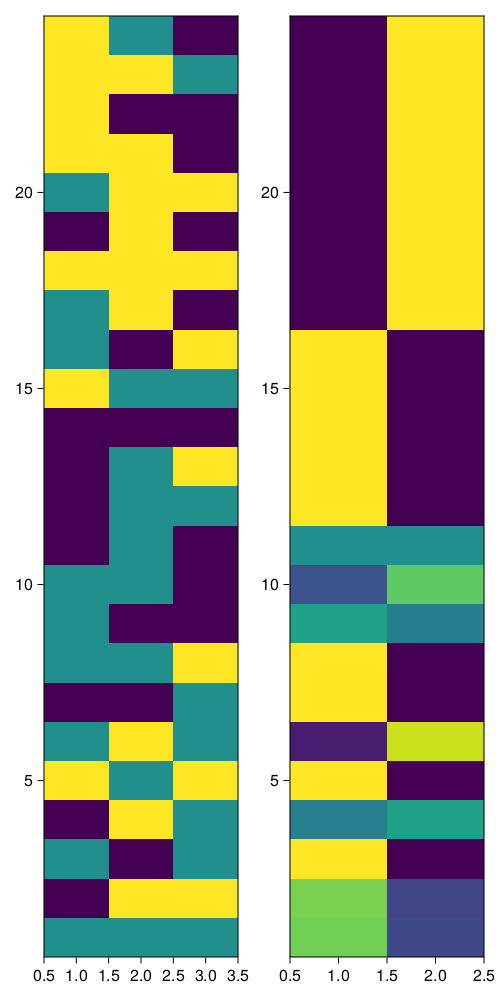

In [1100]:
fig = CairoMakie.Figure(resolution = (500,1000))
ax = Axis(fig[1,1])
ax2 = Axis(fig[1,2])

CairoMakie.heatmap!(ax,unique(features_train[:,[2,6,8]],dims = 1) |> transpose |> collect)
CairoMakie.heatmap!(ax2,class_assignment )

fig

In [1072]:
sub_top_class = [feature_top[x[[2,6,8]]] for x in (eachrow(features_train) |> collect)];

In [1076]:
counts(sub_top_class,yd_train)

24×2 Matrix{Int64}:
 11   3
 12   3
 11   0
 16  21
  1   0
  1  12
  8   0
  2   0
  4   3
  2   6
  ⋮  
  1   0
  0  10
  0   1
  0   9
  0   2
  0   4
  0   2
  0   2
  0   1

In [1107]:
feature_top

Dict{SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, Int64} with 24 entries:
  [0.0, 1.0, 0.0]    => 6
  [0.0, 1.0, -1.0]   => 17
  [-1.0, -1.0, 0.0]  => 7
  [-1.0, -1.0, -1.0] => 14
  [-1.0, 0.0, 1.0]   => 13
  [-1.0, 0.0, 0.0]   => 12
  [1.0, -1.0, -1.0]  => 22
  [-1.0, 1.0, 1.0]   => 2
  [-1.0, 0.0, -1.0]  => 11
  [-1.0, 1.0, 0.0]   => 4
  [1.0, 0.0, 1.0]    => 5
  [1.0, 0.0, 0.0]    => 15
  [-1.0, 1.0, -1.0]  => 19
  [0.0, -1.0, 1.0]   => 16
  [1.0, 1.0, 1.0]    => 18
  [0.0, -1.0, 0.0]   => 3
  [1.0, 1.0, 0.0]    => 23
  [1.0, 0.0, -1.0]   => 24
  [0.0, -1.0, -1.0]  => 9
  ⋮                  => ⋮

In [1123]:
3^3

27

In [1141]:
closest_sub = [argmin([Distances.evaluate(Hamming(),x[[2,6,8]],vec(network_topology_dict[n])[[2,6,8]]) for n in fundamental_topologies]) for x in (eachrow(features_train) |> collect)]

160-element Vector{Int64}:
 1
 3
 1
 5
 1
 1
 1
 5
 4
 5
 ⋮
 5
 4
 4
 4
 5
 4
 4
 4
 4

In [1143]:
counts(closest_sub,yd_train) |> transpose |> collect

2×5 Matrix{Int64}:
 24   6  20   3  27
  6  11   3  39  21